The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Calibrate Camera

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline

# read in a calibration image
class Calibrate():
    def __init__(self):
        super().__init__()
        
        self.objpoints = []
        self.imgpoints = []
        
        self.data_file = "calibrate.p"
        
        self.image = None
        
        self.mtx = None
        self.dist = None
        
        self.gray = None
        self.data = None
        
    # returns the img and obj points given a board of nx, ny dimensions
    def get_points(self, nx, ny, file_pattern):
        image_files = glob.glob(file_pattern)
        
        for fn in image_files:
            
            #read the image
            image = cv2.imread(fn) #cv2 loads images in BGR
            objp = np.zeros((nx*ny, 3), np.float32)
            objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
            
            #convert to grayscale
            self.gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            ret, corners = cv2.findChessboardCorners(self.gray, (nx, ny), None)
            
            if ret == True:
                #print("corners found for", fn)
                self.imgpoints.append(corners)
                self.objpoints.append(objp)
            #else:
                #print("corners not found", fn)
        return self.objpoints, self.imgpoints
    
    def save(self):
        print("saving data into", self.data_file)
        data = {'objpoints':self.objpoints, 'imgpoints':self.imgpoints}
        pickle.dump(data, open( self.data_file, "wb"))
        
    def load(self):
        print("loading data file", self.data_file)
        
        with open(self.data_file, mode="rb") as f:
            data= pickle.load(f)
            
            self.objpoints = data['objpoints']
            self.imgpoints = data['imgpoints']
    
    # recieves as input an unprocessed image
    # uses stored calibration to undistort it
    def undistort_image(self, img):
        self.gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # if we don't have a defined mtx
        if (self.mtx == None):
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, self.gray.shape[::-1], None, None)
            self.mtx = mtx
            self.dist = dist
        
        #undistort the image
        undist_img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return undist_img         

cal = Calibrate()

cal.get_points(9, 6, './camera_cal/calibration*.jpg')

# images where the board is not fully visible
cal.get_points(9, 5, './camera_cal/calibration1.jpg')
cal.get_points(8, 6, './camera_cal/calibration4.jpg')
cal.get_points(7, 6, './camera_cal/calibration5.jpg')

cal.save()
    





saving data into calibrate.p


loading data file calibrate.p


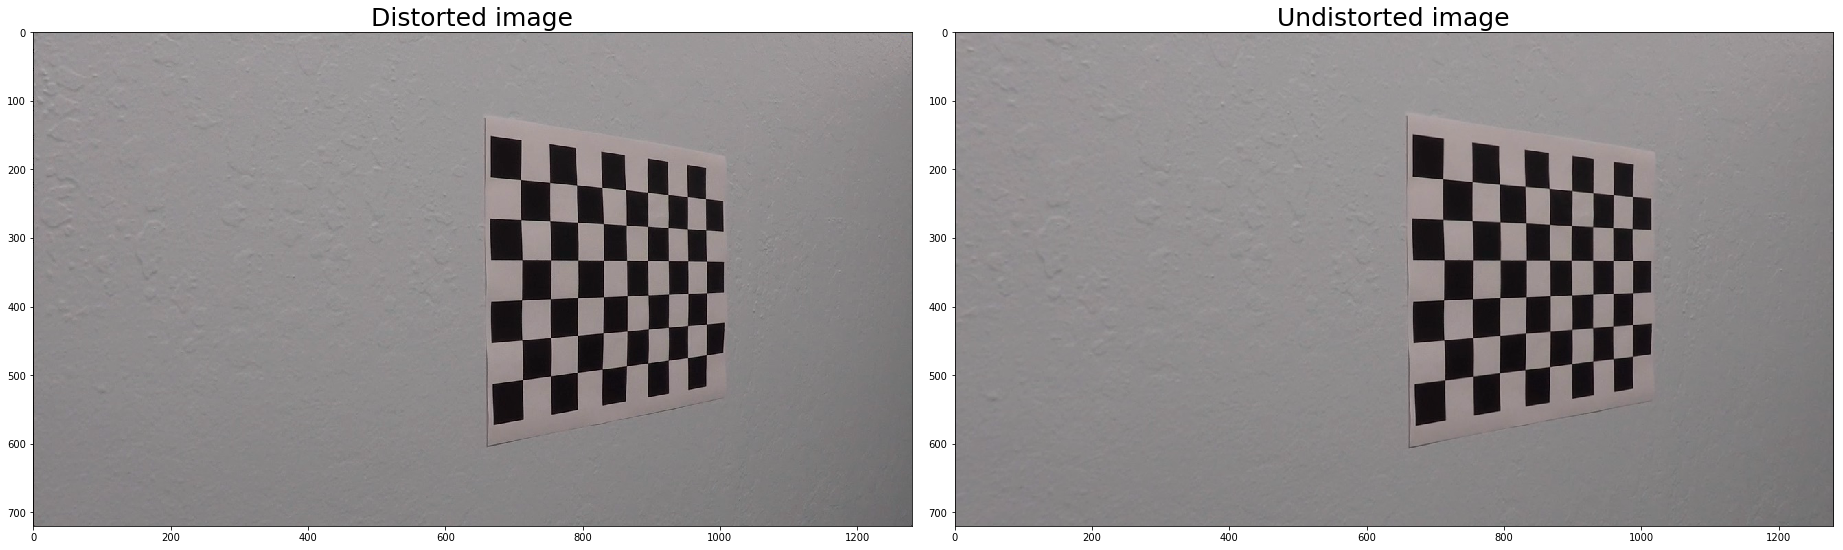

In [3]:
new_cal = Calibrate()
new_cal.load()


# displays original and undistorted images
# receives as input a calibration object and path to image
def debug_undistort(cal, img):
    
    image = cv2.imread(img)
    cal_image = new_cal.undistort_image(image)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Distorted image', fontsize=25)
    ax2.imshow(cal_image)
    ax2.set_title('Undistorted image', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cal2 = './camera_cal/calibration8.jpg'

debug_undistort(new_cal, cal2)

# Perspective Transform 

In [30]:
# Apply perspective transform
def warp_image(img,src,dst,img_size):
    # Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp an image using the perspective transform, M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv


def debug_warp(cal, img, nx, ny):
    image = cv2.imread(img)
    undist = cal.undistort_image(image)
    ret, corners = cv2.findChessboardCorners(undist, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (undist.shape[1], undist.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        
        warped_image, perspective_M, inverse_M = warp_image(undist, src, dst, img_size)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(warped_image)
        ax2.set_title('Undistorted and Warped Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
def apply_perspective_transform(image):
    img_size = image.shape
#     src = np.float32(
#         [[681, 444],
#          [1200, img_size[0]],
#          [598, 444],
#          [200, img_size[0]]])

#     # Four desired coordinates
#     dst = np.float32(
#         [[975, (img_size[0] - img_size[0])],
#          [975, img_size[0]],
#          [300, (img_size[0] - img_size[0])],
#          [300, img_size[0]]])
    src = np.float32([
        [580, 460],
        [700, 460],
        [1040, 680],
        [260, 680],
    ])

    dst = np.float32([
        [260, 0],
        [1040, 0],
        [1040, 720],
        [260, 720],
    ])

    warped_image, perspective_M, inverse_M = warp_image(image,src,dst,(img_size[1],img_size[0]))
    return warped_image, perspective_M, inverse_M

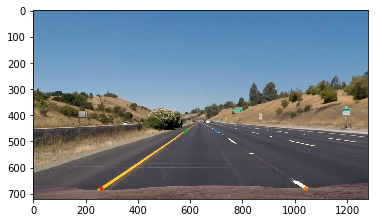

In [32]:
# Source image points
imshape = perspective_transform_img.shape
plt.imshow(perspective_transform_img)
plt.plot(700, 460, '.') # top right
plt.plot(1040, 680, '.') # bottom right
plt.plot(580, 460, '.') # top left
plt.plot(260, 680, '.') # bottom left
plt.savefig('output_images/srcPointsPlotted.jpg')

loading data file calibrate.p


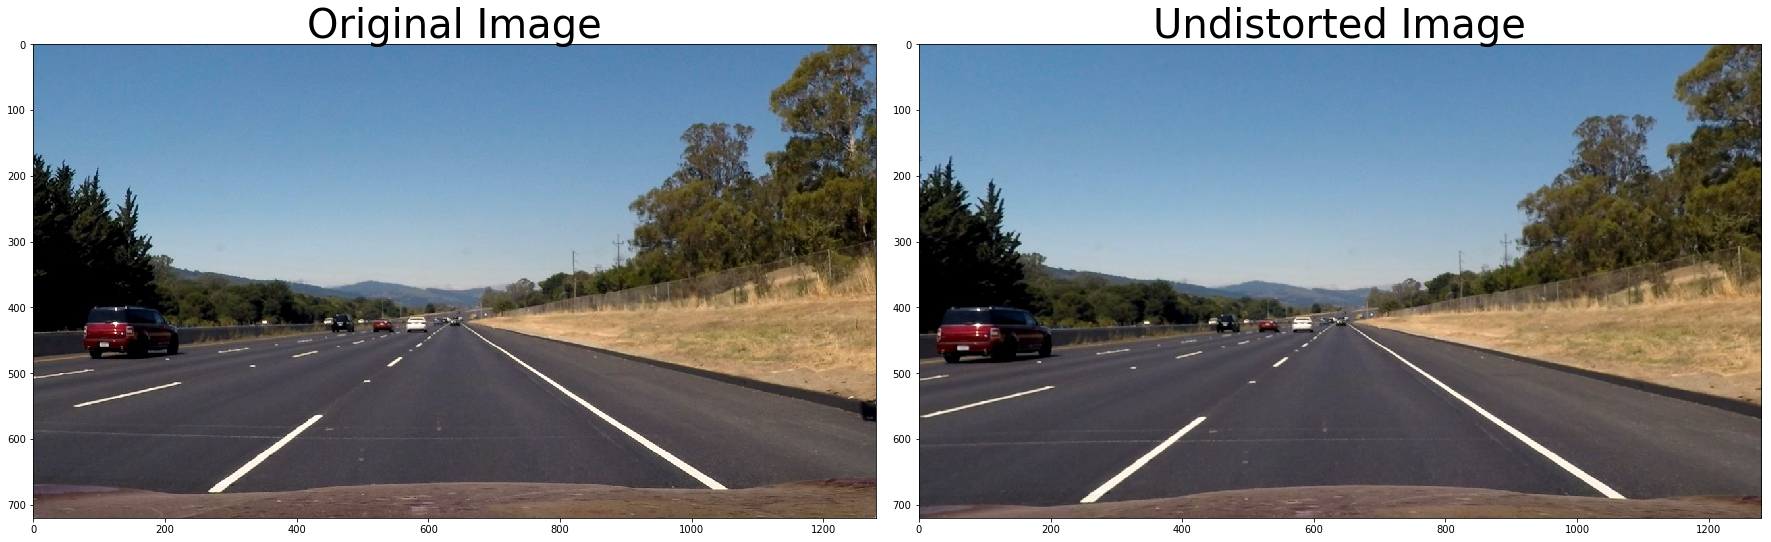

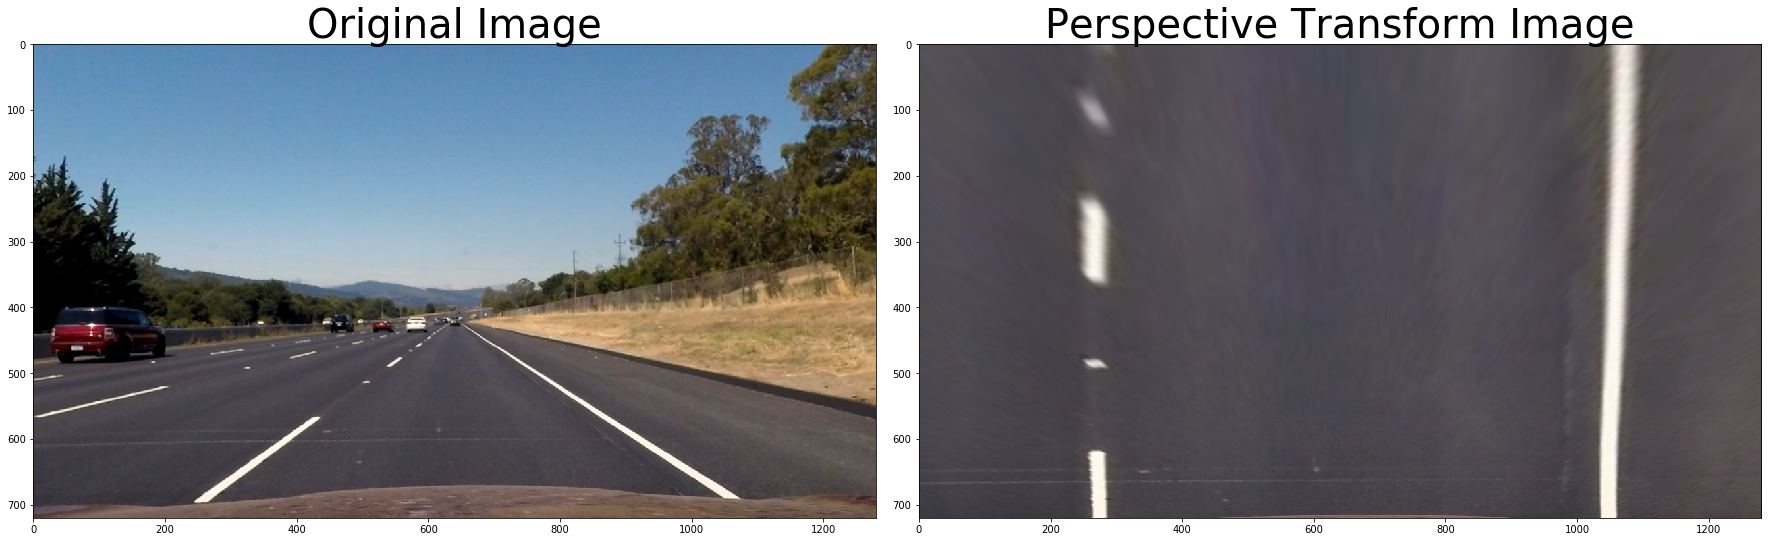

In [31]:
cal = Calibrate()
cal.load()


# cal2 = './camera_cal/calibration8.jpg'
# debug_warp(cal, cal2, 9, 6)

# cal2 = './camera_cal/calibration13.jpg'
# debug_warp(new_cal, cal2, 9, 6)

# image_files = glob.glob('./camera_cal/calibration*.jpg')
        
# for fn in image_files:
#     debug_warp(new_cal, fn, 9, 6)

# Visualize with test

orig_image = './test_images/straight_lines2.jpg'
orig_image = mpimg.imread(orig_image)
undist_image = cal.undistort_image(orig_image)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(orig_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undist_image)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/undistorted_test.jpg')


img_size = np.shape(undist_image)
trans_image, _, _ = apply_perspective_transform(undist_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(trans_image)
ax2.set_title('Perspective Transform Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/perspective_transform.jpg')


# Gradient Threshold

In [ ]:
# sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
# sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

# Calculate the absolute value of the x derivative
# abs_sobelx = np.absolute(sobelx)

# Convert the absolute value image to 8-bit
# scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# thresh_min = 20
# thresh_max = 100
# sxbinary = np.zeros_like(scaled_sobel)
# sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
# plt.imshow(sxbinary, cmap='gray')



# Define a function that takes an image, gradient orientation,
# and threshold min / max values.



def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

# def sobel_combined(image):
#     # Combine sobel masks.
#     img_g_mag = mag_thresh(image,3,(20,150))
#     img_d_mag = dir_threshold(image,3,(.6,1.1))
#     img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
#     img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
#     sobel_combined = np.zeros_like(img_d_mag)
#     sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
#                ((img_g_mag == 1) & (img_d_mag == 1))] = 1
#     return sobel_combined

def sobel_combined(image):
    # Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements

    thresh_min = 20
    thresh_max = 100

    thresh_dir_min = 0.7
    thresh_dir_max = 1.2

    thresh_mag_min = 50
    thresh_mag_max = 255
    # Apply each of the thresholding functions
    # (20, 100)
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
    # (30, 100)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
    # (.7, 1.3)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

# Color Spaces

In [ ]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(image, thresh=(90, 255))

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

In [ ]:
# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [320,720] 
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
M = cv2.getPerspectiveTransform(source, dst)
M_inv = cv2.getPerspectiveTransform(dst, source)
img_size = (image_shape[1], image_shape[0])

warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)